# Quickstart Guide

### Imports

In [1]:
import pm4py
import utils.extractor as extractor
import utils.frames as frames
import math
from simulation.simulator import Simulator
from simulation.objects.enums import Callbacks, SimulationModes, TimestampModes, OptimizationModes, SchedulingBehaviour
import utils.fairness as Fairness
import utils.congestion as Congestion
import utils.optimization as Optimization
from utils.activityDuration import EventDurationsByMinPossibleTime

from visualization.congestion import Show as ShowCongestion
from visualization.fairness import Show as ShowFairness

## FAIRNESS-EXAMPLE

### Parameters

In [2]:
originalLogPath  = 'logs/log_ResReduced.xes'
simulatedLogPath = 'logs/jupyterQuickstart_log_ResReduced_Fair.xes'

FAIRNESS_BACKLOG_N   = 5000

simulationMode      = SimulationModes.KNOWN_FUTURE #PREDICTED_FUTURE
optimizationMode    = OptimizationModes.FAIRNESS   #CONGESTION, BOTH 
schedulingBehaviour = SchedulingBehaviour.CLEAR_ASSIGNMENTS_EACH_WINDOW #KEEP_ASSIGNMENTS

### Callbacks for the MIP-Scheduling

In [3]:
def SimulatorFairness_Callback(simulatorState):
    #return Fairness.FairnessBacklogFair_TIME(simulatorState, BACKLOG_N=FAIRNESS_BACKLOG_N)
    return Fairness.FairnessBacklogFair_WORK(simulatorState, BACKLOG_N=FAIRNESS_BACKLOG_N)

def SimulatorWindowStartScheduling_Callback(simulatorState, schedulingReadyResources, fRatio, cRatio):
    return Optimization.OptimizeActiveTraces(simulatorState, schedulingReadyResources, fRatio, cRatio)

### Simulator Setup

In [4]:
originalLog = pm4py.read_xes(originalLogPath)

windowNumber = 100 * math.ceil(math.sqrt(sum([len(trace) for trace in originalLog])))

# Convert XES-Events into dict {'act', 'ts', 'res', 'single', 'cid'}
event_dict = extractor.event_dict(originalLog, res_info=True)

windowWidth = frames.get_width_from_number(event_dict, windowNumber)
bucketId_borders_dict = frames.bucket_window_dict_by_width(event_dict, windowWidth)
eventsPerWindowDict, id_frame_mapping = frames.bucket_id_list_dict_by_width(event_dict, windowWidth) # WindowID: [List of EventIDs] , EventID: WindowID       

c:\Users\Alexa\.conda\envs\HLEM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7619/7619 [00:03<00:00, 2003.27it/s]


In [5]:
sim = Simulator(event_dict, eventsPerWindowDict, bucketId_borders_dict, 
        simulationMode=simulationMode, optimizationMode=optimizationMode,schedulingBehaviour =schedulingBehaviour,
        endTimestampAttribute='ts', verbose=False)
    
sim.Register(Callbacks.WND_START_SCHEDULING, SimulatorWindowStartScheduling_Callback)
sim.Register(Callbacks.CALC_Fairness,        SimulatorFairness_Callback)
sim.Register(Callbacks.CALC_EventDurations,  lambda x,y: EventDurationsByMinPossibleTime(x,y))

In [6]:
# Run the simulation
sim.Run()
sim.ExportSimulationLog(simulatedLogPath)

Progress: 99.99% complete - Traces (Active / Finished / Total):    1 / 7618 / 7619

Total time for simulation 706.2s
    -> Windows simulated 25203 (given: 24487 / additional: 716)


exporting log, completed traces :: 100%|██████████| 7619/7619 [00:01<00:00, 3818.55it/s]


### Result

parsing log, completed traces :: 100%|██████████| 7619/7619 [00:03<00:00, 2054.40it/s]


<Figure size 3500x6000 with 0 Axes>

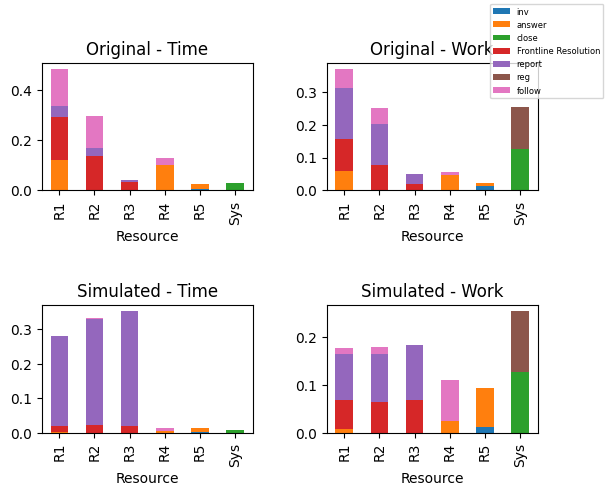

In [7]:
ShowFairness(originalLogPath, simulatedLogPath)

## CONGESTION-EXAMPLE

### Parameters

In [2]:
originalLogPath  = 'logs/log_ResReduced.xes'
simulatedLogPath = 'logs/jupyterQuickstart_log_ResReduced_Reliefed2.xes'

CONGESTION_BACKLOG_N = 50

simulationMode      = SimulationModes.KNOWN_FUTURE #PREDICTED_FUTURE
optimizationMode    = OptimizationModes.CONGESTION #FAIRNESS, BOTH 
schedulingBehaviour = SchedulingBehaviour.CLEAR_ASSIGNMENTS_EACH_WINDOW #KEEP_ASSIGNMENTS

### Callbacks for the MIP-Scheduling

In [9]:
def SimulatorCongestion_Callback(simulatorState):
    return Congestion.GetProgressByWaitingNumberInFrontOfActivity(simulatorState)
    #return Congestion.GetProgressByWaitingTimeInFrontOfActivity(simulatorState)

def SimulatorWindowStartScheduling_Callback(simulatorState, schedulingReadyResources, fRatio, cRatio):
    return Optimization.OptimizeActiveTraces(simulatorState, schedulingReadyResources, fRatio, cRatio)

### Simulator-Setup

In [10]:
originalLog = pm4py.read_xes(originalLogPath)

windowNumber = 100 * math.ceil(math.sqrt(sum([len(trace) for trace in originalLog])))

# Convert XES-Events into dict {'act', 'ts', 'res', 'single', 'cid'}
event_dict = extractor.event_dict(originalLog, res_info=True)

windowWidth = frames.get_width_from_number(event_dict, windowNumber)
bucketId_borders_dict = frames.bucket_window_dict_by_width(event_dict, windowWidth)
eventsPerWindowDict, id_frame_mapping = frames.bucket_id_list_dict_by_width(event_dict, windowWidth) # WindowID: [List of EventIDs] , EventID: WindowID       

parsing log, completed traces :: 100%|██████████| 7619/7619 [00:03<00:00, 2109.48it/s]


In [11]:
sim = Simulator(event_dict, eventsPerWindowDict, bucketId_borders_dict, 
        simulationMode=simulationMode, optimizationMode=optimizationMode,schedulingBehaviour =schedulingBehaviour,
        endTimestampAttribute='ts', verbose=False)
    
sim.Register(Callbacks.WND_START_SCHEDULING, SimulatorWindowStartScheduling_Callback)
sim.Register(Callbacks.CALC_Congestion,      SimulatorCongestion_Callback)
sim.Register(Callbacks.CALC_EventDurations,  lambda x,y: EventDurationsByMinPossibleTime(x,y))

In [12]:
# Run the simulation
sim.Run()
sim.ExportSimulationLog(simulatedLogPath)

Progress: 99.95% complete - Traces (Active / Finished / Total):    4 / 7615 / 7619

Total time for simulation 401.9s
    -> Windows simulated 25034 (given: 24487 / additional: 547)


exporting log, completed traces :: 100%|██████████| 7619/7619 [00:02<00:00, 3795.17it/s]


### Results

c:\Users\Alexa\.conda\envs\HLEM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7619/7619 [00:08<00:00, 925.94it/s] 


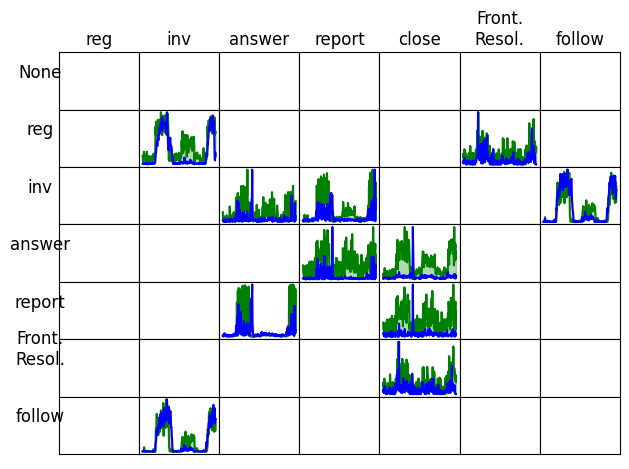

<Figure size 3500x6000 with 0 Axes>

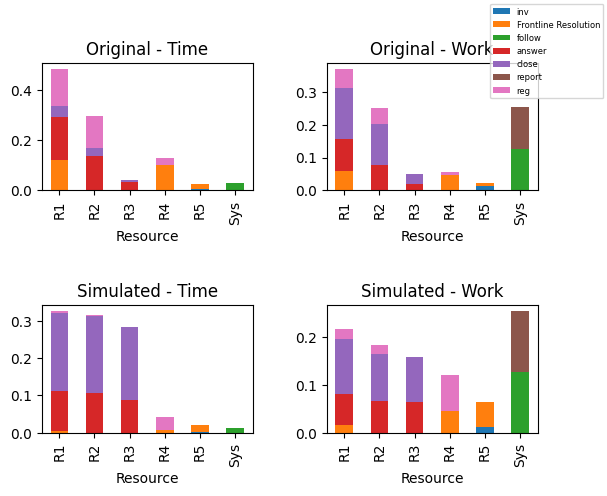

In [3]:
ShowCongestion(originalLogPath, simulatedLogPath)
ShowFairness(originalLogPath, simulatedLogPath)